## Introduction

The COVID-19 pandemic has impacted much of the global supply chain. In particular, we wish to investigate its impact on the US’s agricultural truck transportation supply chain and the price/volume of certain agricultural products. For example, we want to investigate the correlation between COVID-19 cases, truck volume, and agricultural product pricing in the state of California and Florida.

This notebook details our process for importing data sets, cleaning data sets, merging data sets, creating visualizations, and conducting analysis.

In [27]:
# import data science packages
import numpy as np
import pandas as pd

# import visualization packages
import matplotlib.pyplot as plt

First, we must install `openpyxl` if not already. We follow Jake Vanderplas's [advice](https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/) on installing packages within notebooks.

In [28]:
import sys
!{sys.executable} -m pip install openpyxl

## Truck Data

TODO: Give brief introduction for the truck data and where/how we got the data.

In [74]:
# import the truck data

START = 2015 # The starting year to begin loading the truck data
END = 2022   # The ending year (inclusive) to stop loading the truck data.
TRACE = True # Boolean value whether to trace the output.

lst = []
for year in range(START, END+1):
    filename = f'data\Refrigerated_Truck_Volumes_{year}.csv'
    temp_df = pd.read_csv(filename)
    lst.append(temp_df)

    if TRACE:
        print(f"The file '{filename}' contains {temp_df.shape[0]} rows and {temp_df.shape[1]} columns.")

# concatenate all data frames together
truck_df = pd.concat(lst, axis=0, ignore_index=True)

if TRACE:
    print(f"The full data frame contains {truck_df.shape[0]} rows and {truck_df.shape[1]} columns.")

The file 'data\Refrigerated_Truck_Volumes_2015.csv' contains 114836 rows and 14 columns.
The file 'data\Refrigerated_Truck_Volumes_2016.csv' contains 115813 rows and 14 columns.
The file 'data\Refrigerated_Truck_Volumes_2017.csv' contains 115112 rows and 14 columns.
The file 'data\Refrigerated_Truck_Volumes_2018.csv' contains 116071 rows and 14 columns.
The file 'data\Refrigerated_Truck_Volumes_2019.csv' contains 121176 rows and 14 columns.
The file 'data\Refrigerated_Truck_Volumes_2020.csv' contains 129428 rows and 14 columns.
The file 'data\Refrigerated_Truck_Volumes_2021.csv' contains 140029 rows and 14 columns.
The file 'data\Refrigerated_Truck_Volumes_2022.csv' contains 137708 rows and 14 columns.
The full data frame contains 990173 rows and 14 columns.


In [75]:
# Some rows for truck volume may be assigned to different commodity marketing 
#   seasons (e.g., a shipment on 1/1/2015 may be assigned to 2014, 2015, or both)
#   indicated by the `Season` column. If both, then there will be 2 rows of data.
# For our analysis, we disregard this fact because we are more interested in the 
#   `date` of the shipment.
# Therefore, we first group the data, then aggregate by summation of the `10,000 LBS` 
#   column and finally we drop the `Season` column.
groupby_cols = truck_df.columns.drop(['Season','10,000 LBS']).tolist()
clean_truck_df = truck_df.groupby(by=groupby_cols)[['10,000 LBS']].sum().reset_index()

In [76]:
# The column descriptions are taken from the data set page:
# https://agtransport.usda.gov/Truck/Refrigerated-Truck-Volumes/rfpn-7etz
cols_to_keep = [
    'date',      # reporting date
    'Month',     
    'Year',      
    'Mode',      # all origins are domestic, mode is either truck or import, both of
                 #   which are truck movements
    'Region',    # broader region assigned to `Origin` by USDA's Transporation
                 #   Services Division 
    'Origin',    # broader region assigned to `District` by Market News Speciualty Crops
    'District',  # Origin Specialty Crops district
    'Commodity', # commodity (either fruit or vegetable)
    '10,000 LBS' # integer value for truck volume in 10,000 lbs
]
clean_truck_df = clean_truck_df[cols_to_keep]

In [77]:
# Note that the `10,000 LBS` column is encoded as an integer value. We can infer that 
#   truck movements with volumes below the 10,000 lbs threshold will have a value of 0.
#   Since, this is weekly aggregated truck volumes there isn't use in keeping rows
#   with 0 values for the `10,000 LBS` column.
clean_truck_df = clean_truck_df[clean_truck_df['10,000 LBS'] != 0]

if TRACE:
    print(f"The cleaned data frame contains {clean_truck_df.shape[0]} rows and {clean_truck_df.shape[1]} columns.")

The cleaned data frame contains 856759 rows and 9 columns.


In [78]:
# We want to fix the `date` column to be a datetime type.
clean_truck_df.loc[:,'date'] = pd.to_datetime(clean_truck_df['date'], format='%m/%d/%Y')

In [79]:
# check the number of unique values for each column
for col in clean_truck_df.columns:
    print(f"The column `{col}` has {len(clean_truck_df[col].unique())} unique values.")

The column `date` has 2922 unique values.
The column `Month` has 12 unique values.
The column `Year` has 8 unique values.
The column `Mode` has 2 unique values.
The column `Region` has 17 unique values.
The column `Origin` has 42 unique values.
The column `District` has 135 unique values.
The column `Commodity` has 133 unique values.
The column `10,000 LBS` has 2555 unique values.


In [91]:
# For our analysis, we filter the data frame to only include data for California and Florida.
REGIONS = ['California', 'Florida']
filtered_truck_df = clean_truck_df[clean_truck_df['Region'].isin(REGIONS).values]

## Fruit Price Data

TODO: Give brief introduction for the truck data and where/how we got the data.

In [5]:
# get all sheets names of excel file
f = pd.ExcelFile('data/selected-weekly-fruit-movement-and-price.xlsx')
sheets = f.sheet_names

In [6]:
# get list of all commodities
fruit_weekly_price = pd.read_excel('data/selected-weekly-fruit-movement-and-price.xlsx',sheet_name=sheets[0])
fruit_weekly_price = fruit_weekly_price.iloc[6:28,0]

In [7]:
# get price of each week from each sheet
for sheet in sheets:
    week = pd.read_excel('data/selected-weekly-fruit-movement-and-price.xlsx',sheet_name=sheet)
    week = week.iloc[6:28,17]
    week = pd.to_numeric(week, errors='coerce')
    fruit_weekly_price = pd.concat([fruit_weekly_price, week], axis=1)

In [8]:
# reassign proper column names
col = ['Commodity']

for sheet in sheets:
    dt = sheet[-6:]
    p_date = '20'+dt[-2:]+'-'+dt[:2]+'-'+dt[2:4]
    col.append(p_date)

fruit_weekly_price.columns = col

In [9]:
fruit_weekly_price

,Commodity,2022-04-23,2022-04-16,2022-04-09,2022-04-02,2022-03-26,2022-03-19,2022-03-12,2022-03-05,2022-02-26,...,2020-07-04,2020-06-27,2020-06-20,2020-06-13,2020-06-06,2020-05-30,2020-05-23,2020-05-16,2020-05-09,2020-05-02
6,Apples,1.437777,1.894444,1.623,1.676667,1.5750,1.491,1.6760,1.5230,1.567778,...,1.36875,1.374444,1.228,1.354,1.456250,1.347778,1.198889,1.242222,1.2460,1.450
7,Avocados 4/,1.580000,1.510000,1.240,1.570000,1.1600,1.370,1.4100,1.2700,1.240000,...,1.31000,1.080000,1.120,1.270,1.260000,1.110000,1.260000,1.290000,1.2400,1.040
8,Bananas,0.520000,0.510000,0.520,0.570000,0.5300,0.550,0.3800,0.5800,0.530000,...,0.44000,0.420000,0.340,0.550,0.370000,0.430000,0.550000,0.510000,0.4600,0.510
9,Blueberries,3.020000,3.600000,2.890,3.610000,3.3100,2.780,3.2500,3.2200,2.600000,...,2.59000,2.700000,2.400,2.520,2.900000,2.980000,2.780000,2.590000,2.6600,2.770
10,Cantaloupes,0.810000,1.160000,0.570,0.980000,1.8700,0.630,0.5700,0.8600,0.530000,...,0.44000,0.480000,0.460,0.480,0.560000,0.630000,0.570000,0.520000,0.4900,0.490
11,Cherries,NaN,NaN,NaN,0.000000,4.9900,3.830,4.5700,5.3700,NaN,...,3.41000,3.790000,3.520,4.130,4.330000,4.290000,4.720000,3.990000,4.6500,2.990
12,Grapefruit,0.990000,1.690000,1.310,0.990000,1.1200,0.500,1.4900,1.4000,1.190000,...,0.50000,NaN,NaN,NaN,NaN,0.250000,NaN,NaN,0.4100,0.440
13,Grapes,2.202500,2.605000,2.255,2.462500,2.2975,2.515,2.6475,2.5425,2.465000,...,1.82500,1.915000,1.695,1.790,1.613333,2.235000,2.702500,2.512500,2.1425,2.025
14,Honeydew,0.970000,0.990000,NaN,0.970000,1.0100,0.000,1.7900,0.8900,1.540000,...,0.76000,0.800000,0.890,0.960,1.290000,0.790000,1.130000,0.990000,0.4600,0.580
15,Lemons,0.940000,0.720000,0.650,0.850000,0.6400,0.740,0.9500,0.7800,0.910000,...,1.49000,0.790000,0.860,NaN,0.780000,0.990000,0.830000,0.330000,2.1300,0.660


## COVID-19 Data

TODO: Give brief introduction for the truck data and where/how we got the data.

In [10]:
#get all sheets names of excel file
f = pd.ExcelFile('data/selected-weekly-fruit-movement-and-price.xlsx')
sheets = f.sheet_names

In [11]:
data_covid = pd.read_csv ('data\Weekly_United_States_COVID-19_Cases_and_Deaths_by_State.csv')
data_covid.head()

,date_updated,state,start_date,end_date,tot_cases,new_cases,tot_deaths,new_deaths,new_historic_cases,new_historic_deaths
0,2020-01-23,AK,2020-01-16,2020-01-22,0,0,0,0,0,0
1,2020-01-30,AK,2020-01-23,2020-01-29,0,0,0,0,0,0
2,2020-02-06,AK,2020-01-30,2020-02-05,0,0,0,0,0,0
3,2020-02-13,AK,2020-02-06,2020-02-12,0,0,0,0,0,0
4,2020-02-20,AK,2020-02-13,2020-02-19,0,0,0,0,0,0


Extract data for Carlifornia

Features Explanation:

- data_updated: date of data release
- state: Jurisdiction
- start_date: first day of 7-day period
- end_date: final day of 7-day period
- tot_cases: Cumulative total number of cases
- new_cases: Number of new cases (7-day sum)
- tot_deaths: Cumulative total number of deaths
- new_deaths: Number of new deaths (7-day sum)
- new_historic_cases: Number of new historic cases (7-day sum)
- new_historic_deaths: Number of new historic deaths (7-day sum)

In [12]:
covid_CA = data_covid[data_covid['state'] == 'CA']
covid_CA.head()

,date_updated,state,start_date,end_date,tot_cases,new_cases,tot_deaths,new_deaths,new_historic_cases,new_historic_deaths
780,2020-01-23,CA,2020-01-16,2020-01-22,0,0,0,0,0,0
781,2020-01-30,CA,2020-01-23,2020-01-29,2,2,0,0,0,0
782,2020-02-06,CA,2020-01-30,2020-02-05,8,6,0,0,0,0
783,2020-02-13,CA,2020-02-06,2020-02-12,16,8,0,0,0,0
784,2020-02-20,CA,2020-02-13,2020-02-19,30,14,0,0,0,0


In [13]:
covid_CA[covid_CA['date_updated'] == '2022-01-13']

,date_updated,state,start_date,end_date,tot_cases,new_cases,tot_deaths,new_deaths,new_historic_cases,new_historic_deaths
883,2022-01-13,CA,2022-01-06,2022-01-12,6623538,790954,76683,630,0,0


In [14]:
covid_CA.shape

(156, 10)

In [15]:
covid_FL = data_covid[data_covid['state'] == 'FL']
covid_FL.head()

,date_updated,state,start_date,end_date,tot_cases,new_cases,tot_deaths,new_deaths,new_historic_cases,new_historic_deaths
1560,2020-01-23,FL,2020-01-16,2020-01-22,0,0,0,0,0,0
1561,2020-01-30,FL,2020-01-23,2020-01-29,0,0,0,0,0,0
1562,2020-02-06,FL,2020-01-30,2020-02-05,0,0,0,0,0,0
1563,2020-02-13,FL,2020-02-06,2020-02-12,0,0,0,0,0,0
1564,2020-02-20,FL,2020-02-13,2020-02-19,0,0,0,0,0,0


In [16]:
covid_FL.shape

(156, 10)

In [17]:
covid_FL.columns

Index(['date_updated', 'state', 'start_date', 'end_date', 'tot_cases',
       'new_cases', 'tot_deaths', 'new_deaths', 'new_historic_cases',
       'new_historic_deaths'],
      dtype='object')

In [18]:
#check whether there are missing values for all the columns 
for i in covid_CA.columns:
    result = covid_FL[i].isna().sum()
result

0

There are no missing values for all the columns in the sub-dataframe we extracted.

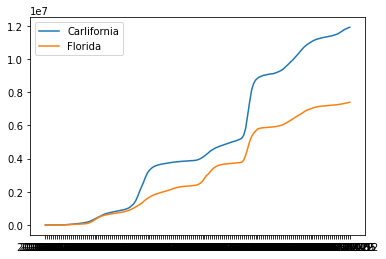

In [19]:
x = covid_CA['date_updated']

y1 = covid_CA['tot_cases']
y2 = covid_FL['tot_cases']

plt.plot(x, y1, label='Carlifornia')
plt.plot(x, y2, label='Florida')


plt.legend()

From the rough line line we can see that there are 3 time stamp makes the total cases of Carlifornia increase significantly.

In [20]:
# find the datestamp for Carlifornia that the total cases changed the largest 
def find_date(df, n):
    diff_list = []
    for i in range(0, len(df['tot_cases'])-1):
        difference = (df['tot_cases'].iloc[i+1] - df['tot_cases'].iloc[i])
        diff_list.append((difference,df['date_updated'].iloc[i+1]))
        result = sorted(diff_list, reverse = True)
    return result[:n]

In [21]:
find_date(covid_CA, 3)

[(790954, '2022-01-13'), (788494, '2022-01-20'), (708364, '2022-01-27')]

In [22]:
find_date(covid_FL, 3)

[(429311, '2022-01-20'), (396562, '2022-01-13'), (302179, '2022-01-06')]

From the result we can see that 2022 January is the period that the total cases increased most significantly. when we analyze the truck and price related data, we can take a look at this period specifically.

## Merge All Data

In [23]:
# TODO

## Visualizations

In [24]:
# TODO

## Record Dependencies

We list our dependencies at the end of this notebook.

In [25]:
import sys
!{sys.executable} -m pip install watermark

In [26]:
%load_ext watermark
%watermark -v -m -p numpy,pandas,matplotlib,openpyxl

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.4.0

numpy     : 1.21.5
pandas    : 1.4.3
matplotlib: 3.5.1
openpyxl  : 3.1.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 33 Stepping 0, AuthenticAMD
CPU cores   : 12
Architecture: 64bit

